# Astronomy I & II


1. [Astropy Basics](#astropy_basics)
 
    * Constants and units
    * Celestial Coordinates
    * Time and dates
    * FITS files
         * FITS Tables (and other common formats)
         * Spectra
         * Images & WCS

2. [Astroquery](#astroquery)
 * 

3. [Photutils](#photutils)
 * Source detection (DAO vs SExtractor)
 * Modelling: Measuring the PSF FHWM with a moffat profile
 * Background modelling and aperture Photometry

4. [Astropy: Matching catalogues](#matching)
 * Exercice: match catalogue of sextracted sourced with one made with astroquery
   * Bad way: direct search on a loop.
   * Good way: use astropy's matching method 

5. [Pyephem/Astroplan](#astroplan)
 * Earth, Time and Fixed Bodies
 * Sun rising, setting and dark time
 * Night planning: objects visibility and distance to moon
 * Exercice: Make plan to observe 3 objects



#### (Optional if time)

* Astroscrappy: Cosmic ray detection / rejection / masking
* Cosmology in astropy
* Data reduction example. From Raw optical imaging to reduced catalogue
* Sewpy: Sextractor wrapper
* GlueViz in Plotting or Astronomy?
* Naima
* IDL / ROOT functions or wrappers


In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
plt.rcParams['figure.figsize'] = 15, 10

<a id=astropy_basics></a>
## 1. Astropy Basics
In this section, we will explain the basics of what can be done with Astropy, such as working with internal units, opening FITS files, tables, spectra and WCS.

### Constants and Units
Astropy provides a large amount of astronomical constants..

In [2]:
from astropy import constants as const
from astropy import units as u

By default astropy constants uses S.I. units...

In [3]:
print(const.c)

  Name   = Speed of light in vacuum
  Value  = 299792458.0
  Uncertainty  = 0.0
  Unit  = m / s
  Reference = CODATA 2010


It can be transformed to any units...

In [4]:
const.c.to('km/s')

<Quantity 299792.458 km / s>

In [5]:
const.c.to('pc/yr')

<Quantity 0.3066013937879528 pc / yr>

You can also define your own constant using astropy Units

In [6]:
my_emission_line_flux = 12.32 * u.erg / u.cm ** 2 / u.s
my_emission_line_flux

<Quantity 12.32 erg / (cm2 s)>

Here we can compute earth's orbit speed using astropy constants...

In [7]:
speed_of_earth = const.au * 2 * math.pi / u.yr
speed_of_earth.to('km/s')

<Quantity 29.785254365591538 km / s>

### <span style="color:blue">Exercise:</span> Working with astronomy constants
Compute (approximately) the speed of the earth's orbit using astropy's mass of the Sun.

In [8]:
# Your code here

Press shift+E to view the solution in next cell.

In [9]:
speed_of_earth_2 = np.sqrt(const.G * const.M_sun / const.au) 
speed_of_earth_2.to('km/s')

<Quantity 29.788833564362875 km / s>

### Celestial Coordinates

The simplest coordinate we can define is a single point in the sky, by default in the ICRS frame.

In [10]:
from astropy.coordinates import SkyCoord
c = SkyCoord(ra=10.625*u.degree, dec=41.2*u.degree, frame='icrs')

#### Definition
It can be defined in almost any format used in astronomy (and there are many, as usual...) all representing the same location.

In [11]:
c = SkyCoord(10.625, 41.2, frame='icrs', unit='deg')
c = SkyCoord('00h42m30s', '+41d12m00s', frame='icrs')
c = SkyCoord('00h42.5m', '+41d12m')
c = SkyCoord('00 42 30 +41 12 00', unit=(u.hourangle, u.deg))
c = SkyCoord('00:42.5 +41:12', unit=(u.hourangle, u.deg))
c

<SkyCoord (ICRS): (ra, dec) in deg
    ( 10.625,  41.2)>

Astropy also has a significantly large list of sources than can be retrieved by its name:

In [12]:
a_big_blue_star = SkyCoord.from_name('rigel')
print (a_big_blue_star.ra, a_big_blue_star.dec)

78d38m04.0814s -8d12m05.8981s


#### Transformation
We can easily convert to other coordinate systems, like the galactic...

In [13]:
c.galactic

<SkyCoord (Galactic): (l, b) in deg
    ( 121.12334339, -21.6403587)>

Or even get what is the closest constellation to the object, very useful for astronomers as you know...

In [14]:
c.get_constellation()

'Andromeda'

#### Distances
Coordinates allow also to define distances:

In [15]:
c = SkyCoord(ra=10.68458*u.degree, dec=41.26917*u.degree, distance=770*u.kpc)
print (c.cartesian.x, c.cartesian.y, c.cartesian.z)

568.7128654235231 kpc 107.30089740420249 kpc 507.88994291875713 kpc


If we define one or more coordinates we can compute the distance between the two objects:

In [16]:
c1 = SkyCoord(ra=10*u.degree, dec=9*u.degree, distance=10*u.pc, frame='icrs')
c2 = SkyCoord(ra=11*u.degree, dec=10*u.degree, distance=11.5*u.pc, frame='icrs')

print ("Angular Separation: %s" % c1.separation(c2))
print ("Distance between objects: %s" % c1.separation_3d(c2))

Angular Separation: 1d24m16.343s
Distance between objects: 1.5228602415117989 pc


#### Catalogue of sources

A catalogue of positions can also be created using numpy arrays:

In [17]:
ras = np.array([0-.7, 21.5, 120.9]) * u.deg  
decs = np.array([4.5, -5.2, 6.3]) * u.deg   
catalogue = SkyCoord(ras, decs, frame='icrs')
catalogue.galactic

<SkyCoord (Galactic): (l, b) in deg
    [(  98.38367576, -55.76513019), ( 145.0410998 , -66.57665941),
     ( 215.51872772,  18.90455248)]>

## Time and Date
The astropy.time package provides functionality for manipulating times and dates used in astronomy, such as UTC or MJD.
#### Definition

In [18]:
from astropy.time import Time
times = ['2017-09-13T00:00:00', '2017-09-15T11:20:15.123456789',]
t1 = Time(times)
t1

<Time object: scale='utc' format='isot' value=['2017-09-13T00:00:00.000' '2017-09-15T11:20:15.123']>

Default format is ISOT and scale UTC, but it can be set to others.

In [19]:
times = [58009, 58011.47239726]
t2 = Time(times, format='mjd', scale='tai')
t2

<Time object: scale='tai' format='mjd' value=[ 58009.          58011.47239726]>

#### Format conversion

In [20]:
print ("To julian date: %s" % t1[0].jd)
print ("To modified julian date: %s" % t1[0].mjd)
print ("To FITS: %s" % t1[0].fits)
print ("To GPS: %s" % t1[0].gps)
print ("To Bessel Epoch Year: %s" % t1[0].byear_str)
print ("To Julian Epoch Year: %s" % t1[0].jyear_str)

To julian date: 2458009.5
To modified julian date: 58009.0
To FITS: 2017-09-13T00:00:00.000(UTC)
To GPS: 1189296018.0
To Bessel Epoch Year: B2017.700
To Julian Epoch Year: J2017.699


## FITS files

### Tables in FITS

We will read a FITS table containing a catalogue, in this case a custom collection of Gaia stars created with CosmoHub.

With two instructions I can open the fits file and preview the content of it. For this file we find a list of two units, a primary HDU and the binary table:

In [21]:
from astropy.io import fits
gaia_hdulist = fits.open('../resources/cosmohub_catalogue.fits')

gaia_hdulist.info()

Filename: ../resources/cosmohub_catalogue.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU       4   ()      
  1              BinTableHDU     39   111R x 8C   [D, D, D, D, K, D, D, D]   


To access the primary HDU, we can directly call it by its name, and preview the header like this:

In [22]:
gaia_hdulist['PRIMARY'].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  

As the second extension has no name, we can access to it from its index:

In [23]:
gaia_hdulist[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   64 / length of dimension 1                          
NAXIS2  =                  111 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    8 / number of table fields                         
TTYPE1  = 'ra      '                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'ra_error'                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'dec     '        

The data is contained in the Binary table and can be accessed very similarly to a numpy/pandas table:

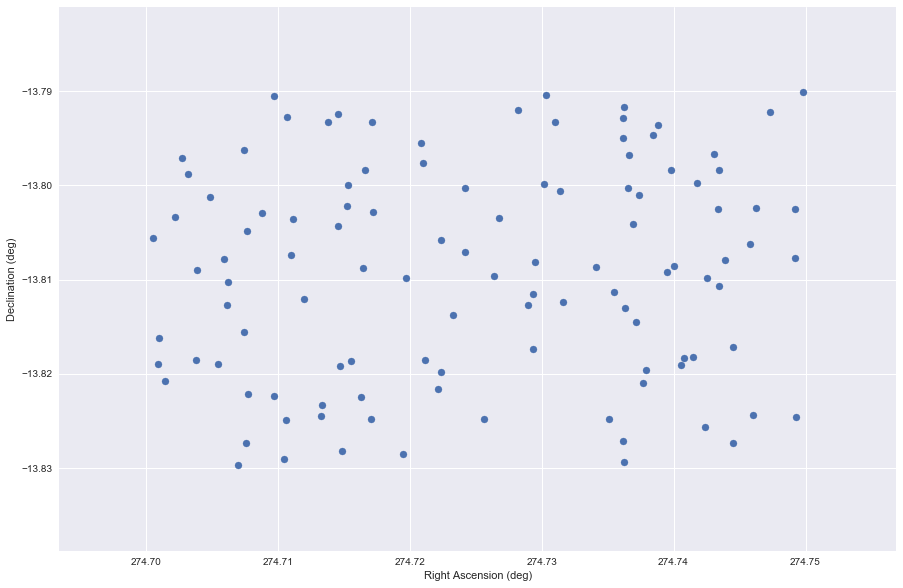

In [24]:
plt.scatter(gaia_hdulist[1].data['ra'], gaia_hdulist[1].data['dec'])
plt.xlabel('Right Ascension (deg)')
plt.ylabel('Declination (deg)')

### Tables not in FITS
Even FITS is widely used in astronomy, there are a several other widely used formats for storing table and catalogue data. The module astropy.io.ascii provides read capability for most of them. Find the list of supported formats in astropy's documentation: http://docs.astropy.org/en/stable/io/ascii/index.html#supported-formats 

In [25]:
from astropy.io import ascii
data = ascii.read("../resources/sources.dat")  
print(data)

obsid redshift  X    Y      object  
----- -------- ---- ---- -----------
 3102     0.32 4167 4085 Q1250+568-A
  877     0.22 4378 3892   Source 82


The read method tries to identify the file format automatically, but it can be specified in the format input parameter:

In [26]:
data = ascii.read("../resources/sources.csv", format='csv')  
print(data)

obsid redshift  X    Y      object  
----- -------- ---- ---- -----------
 3102     0.32 4167 4085 Q1250+568-A
  877     0.22 4378 3892   Source 82


Any catalogue can then be exported (in this case to screen) to any format:

In [27]:
import sys
ascii.write(data, sys.stdout, format='latex')

\begin{table}
\begin{tabular}{ccccc}
obsid & redshift & X & Y & object \\
3102 & 0.32 & 4167 & 4085 & Q1250+568-A \\
877 & 0.22 & 4378 & 3892 & Source 82 \\
\end{tabular}
\end{table}


### Spectra data
Let's read a fits file containing spectra for a QSO observed with SDSS.

First we want to open the fits and inspect what it's in there...

In [28]:
sdss_qso_hdulist = fits.open('../resources/sdss_qso_spec-0501-52235-0313.fits')

sdss_qso_hdulist.info()

Filename: ../resources/sdss_qso_spec-0501-52235-0313.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     143   ()      
  1  COADD       BinTableHDU     26   3805R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPECOBJ     BinTableHDU    262   1R x 126C   [6A, 4A, 16A, 23A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 19A, I, 3A, 3A, 1A, J, D, D, D, E, E, 19A, 8A, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 10A, E, E, E, E, E, E, E, E, J, E, E, J, 1A, 1A, E, E, J, J, 1A, 5E, 5E]   
  3  SPZLINE     BinTableHDU     48   29R x 19C   [J, J, J, 13A, D, E, E, E, E, E, E, E, E, E, E, J, J, E, E]   


The coadd seems to have the coadded spectra from several observations.

Let's now inspect what columns we get in the spectra:

In [29]:
sdss_qso_hdulist['COADD'].columns

ColDefs(
    name = 'flux'; format = 'E'
    name = 'loglam'; format = 'E'
    name = 'ivar'; format = 'E'
    name = 'and_mask'; format = 'J'
    name = 'or_mask'; format = 'J'
    name = 'wdisp'; format = 'E'
    name = 'sky'; format = 'E'
    name = 'model'; format = 'E'
)

We can now have a look at the spectra data itself, using a scatter plot.

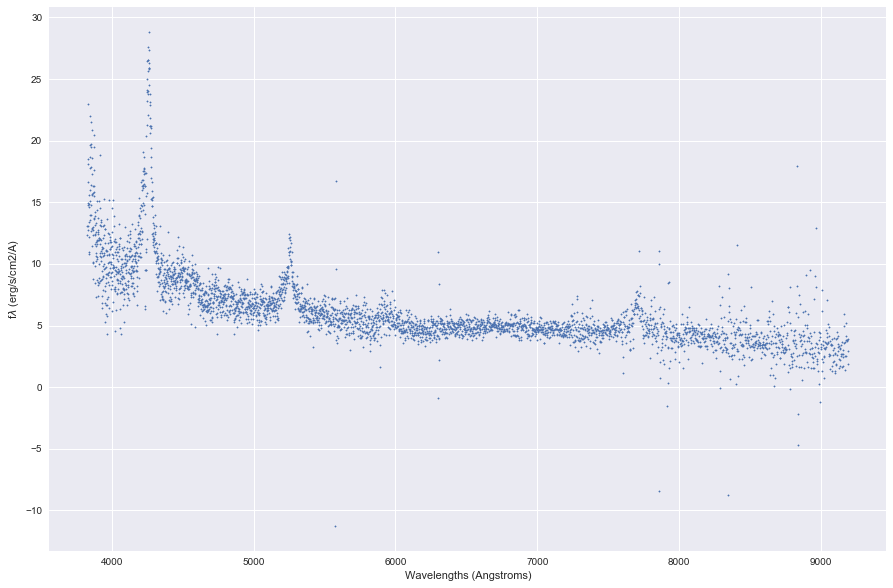

In [30]:
plt.scatter(10**sdss_qso_hdulist['COADD'].data['loglam'], sdss_qso_hdulist['COADD'].data['flux'], s=2)
plt.xlabel('Wavelengths (Angstroms)')
plt.ylabel(r'f$\lambda$ (erg/s/cm2/A)')

The previous spectra seems to have some bad measurements, but we can make use of the OR mask included to discard those measurements. 

To better visualize the spectra file we will apply a gaussian filtering...

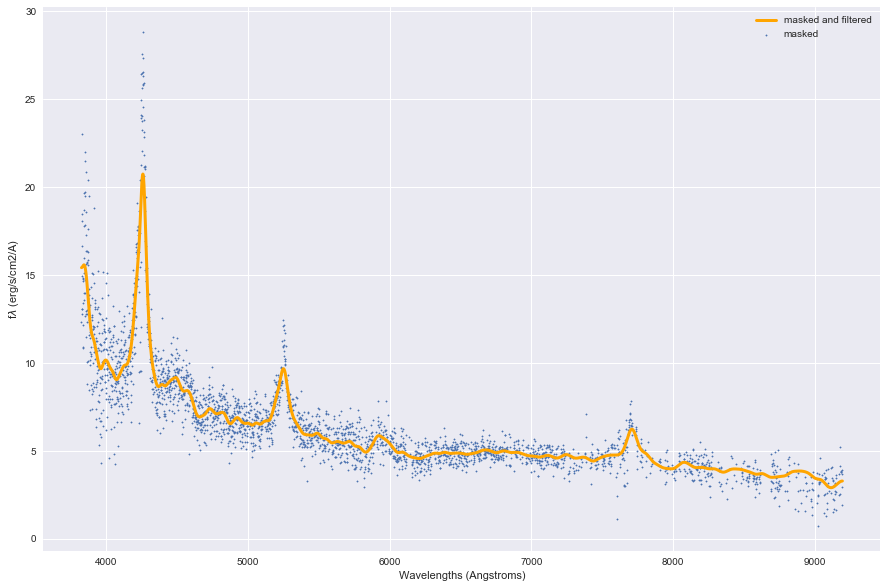

In [31]:
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d

y_values_masked = np.ma.masked_where(sdss_qso_hdulist['COADD'].data['or_mask'], 
                                     sdss_qso_hdulist['COADD'].data['flux'])
x_values_masked = np.ma.masked_where(sdss_qso_hdulist['COADD'].data['or_mask'], 
                                     sdss_qso_hdulist['COADD'].data['loglam'])

plt.scatter(10**x_values_masked, y_values_masked, s=2, label='masked')
plt.plot(10**sdss_qso_hdulist['COADD'].data['loglam'], gaussian_filter(y_values_masked, sigma=16), 
         color='orange', linewidth=3, label='masked and filtered')
plt.xlabel('Wavelengths (Angstroms)')
plt.ylabel(r'f$\lambda$ (erg/s/cm2/A)')
plt.legend()

Another information that is included in this spectra file is the emission lines measured by SDSS. We can inspect the columns of that extension:

In [32]:
sdss_qso_hdulist['SPZLINE'].data.columns

ColDefs(
    name = 'PLATE'; format = 'J'
    name = 'MJD'; format = 'J'
    name = 'FIBERID'; format = 'J'
    name = 'LINENAME'; format = '13A'
    name = 'LINEWAVE'; format = 'D'
    name = 'LINEZ'; format = 'E'
    name = 'LINEZ_ERR'; format = 'E'
    name = 'LINESIGMA'; format = 'E'
    name = 'LINESIGMA_ERR'; format = 'E'
    name = 'LINEAREA'; format = 'E'
    name = 'LINEAREA_ERR'; format = 'E'
    name = 'LINEEW'; format = 'E'
    name = 'LINEEW_ERR'; format = 'E'
    name = 'LINECONTLEVEL'; format = 'E'
    name = 'LINECONTLEVEL_ERR'; format = 'E'
    name = 'LINENPIXLEFT'; format = 'J'
    name = 'LINENPIXRIGHT'; format = 'J'
    name = 'LINEDOF'; format = 'E'
    name = 'LINECHI2'; format = 'E'
)

### <span style="color:blue">Exercise:</span> Working with spectra
Display the emission lines available in the SPZLINE extension over the QSO spectra

In [33]:
# Your code here

Press shift+E to view the solution in next cell.

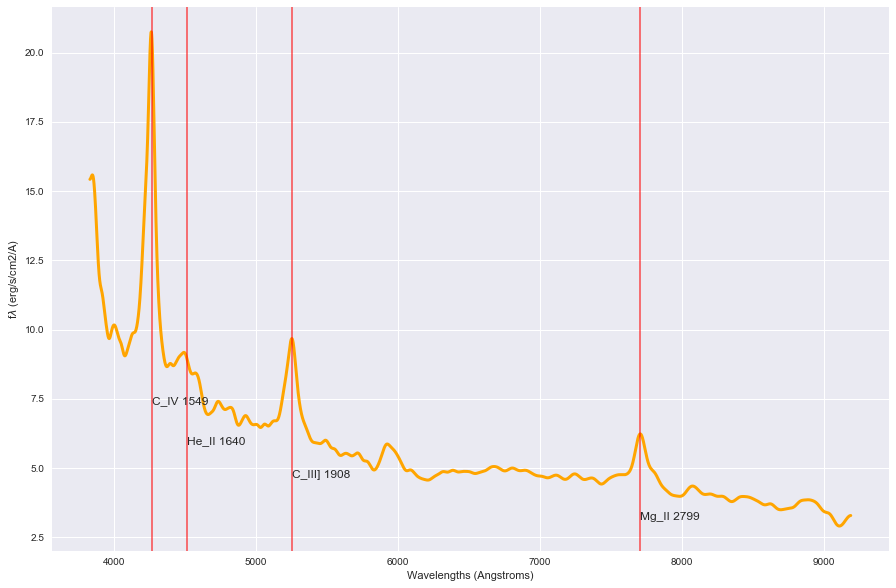

In [34]:
# Solution
plt.plot(10**sdss_qso_hdulist['COADD'].data['loglam'], gaussian_filter(y_values_masked, sigma=16), 
         color='orange', linewidth=3)
plt.xlabel('Wavelengths (Angstroms)')
plt.ylabel(r'f$\lambda$ (erg/s/cm2/A)')

for eline in sdss_qso_hdulist['SPZLINE'].data:
    if eline['LINECHI2'] > 0:
        line_wl = eline['LINEWAVE'] * (1 + eline['LINEZ'])
        plt.axvline(x=line_wl, color='red', alpha=0.6)
        plt.text(line_wl, 
                 eline['LINECONTLEVEL'] * 0.7,
                 eline['LINENAME'])

## FITS images and WCS

In [35]:
hst_hdulist = fits.open('../resources/hst_656nmos.fits')
hst_hdulist.info()

Filename: ../resources/hst_656nmos.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     290   (1600, 1600)   float32   
  1  656nmos_cvt.tab  TableHDU       353   1R x 49C   [D25.17, D25.17, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, A1, E15.7, I12, I12, D25.17, D25.17, A8, A8, I12, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, I12, I12, I12, I12, I12, I12, I12, I12, A48, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7]   


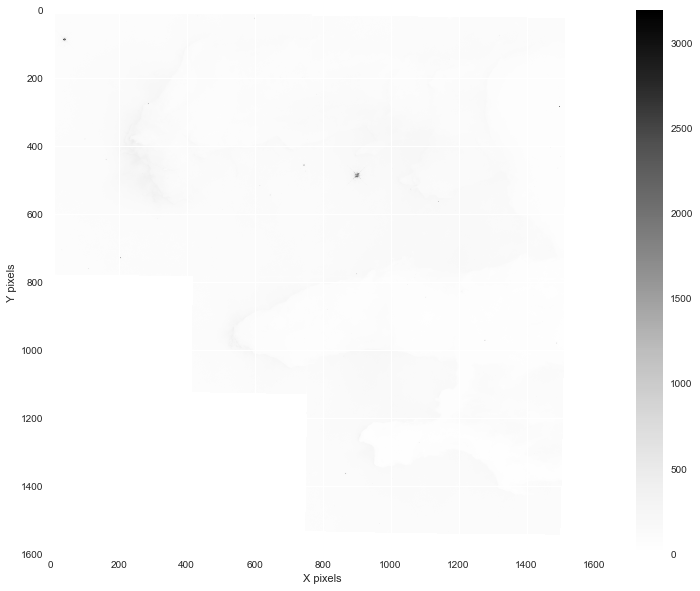

In [36]:
plt.imshow(hst_hdulist['PRIMARY'].data)
plt.xlabel('X pixels')
plt.ylabel('Y pixels')
plt.colorbar()

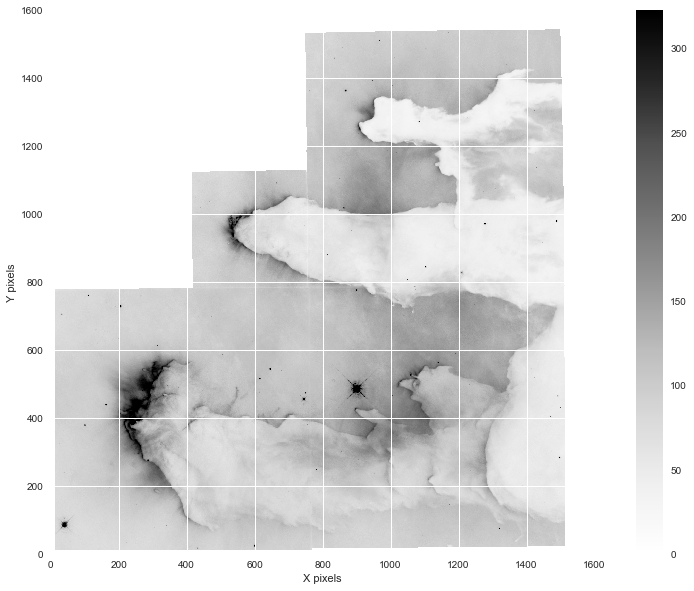

In [37]:
from astropy.visualization import ZScaleInterval

norm = ZScaleInterval()
vmin, vmax = norm.get_limits(hst_hdulist['PRIMARY'].data)

plt.imshow(hst_hdulist[0].data, vmin=vmin, vmax=vmax, interpolation='none', origin='lower')
plt.xlabel('X pixels')
plt.ylabel('Y pixels')
plt.colorbar()

As we will be using the image visualization several times, let's make a function that makes our code cleaner:

In [38]:
def my_python_ds9(data):
    norm = ZScaleInterval()
    vmin, vmax = norm.get_limits(data)
    plt.imshow(data, vmin=vmin, vmax=vmax, interpolation='none', origin='lower')
    plt.colorbar()

The image header contains the World Coordinate System (WCS) information, stored in a set of keywords (CD, CRVAL, CRPIX and optionally some distortion parameters). The WCS provides the projection of the image in the sky, allowing to work with pixels and sky coordinates.

In [39]:
print ("WCS projection type:")
print (hst_hdulist['PRIMARY'].header['CTYPE1'])
print (hst_hdulist['PRIMARY'].header['CTYPE2'])

print ("WCS reference values:")
print (hst_hdulist['PRIMARY'].header['CRVAL1'])
print (hst_hdulist['PRIMARY'].header['CRVAL2'])

print ("WCS reference pixel:")
print (hst_hdulist['PRIMARY'].header['CRPIX1'])
print (hst_hdulist['PRIMARY'].header['CRPIX2'])

print ("WCS pixel to sky matrix:")
print (hst_hdulist['PRIMARY'].header['CD1_1'])
print (hst_hdulist['PRIMARY'].header['CD1_2'])
print (hst_hdulist['PRIMARY'].header['CD2_1'])
print (hst_hdulist['PRIMARY'].header['CD2_2'])

WCS projection type:
RA---TAN
DEC--TAN
WCS reference values:
274.71149247724
-13.816384007184
WCS reference pixel:
386.5
396.0
WCS pixel to sky matrix:
1.878013e-05
-2.031193e-05
-2.029358e-05
-1.879711e-05


We can load the WCS of the image directly like this:

In [40]:
from astropy import wcs

hst_image_wcs = wcs.WCS(hst_hdulist['PRIMARY'].header)
hst_image_wcs.printwcs()

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 274.71149247723997  -13.816384007184  
CRPIX : 386.5  396.0  
CD1_1 CD1_2  : 1.8780129999999999e-05  -2.031193e-05  
CD2_1 CD2_2  : -2.029358e-05  -1.8797110000000001e-05  
NAXIS : 1600  1600


Once loaded the WCS, we can retrieve the corners of the image footprint:

In [41]:
hst_image_wcs.calc_footprint()

array([[ 274.71229924,  -13.80113597],
       [ 274.67885071,  -13.83119039],
       [ 274.70977662,  -13.86364197],
       [ 274.74322582,  -13.83358337]])

We can infer its pixel scale from the CD matrix:

In [42]:
hst_pixelscale = np.mean(wcs.utils.proj_plane_pixel_scales(hst_image_wcs) * u.degree).to('arcsec')
hst_pixelscale

<Quantity 0.0995850127436039 arcsec>

It is also useful to know the coordinates of a specific pixel in the image:

In [43]:
# Origin of the pixel coordinates convention:
# Set 0 when first pixel is 0 (c/python-like)
# Set 1 when first pixel is 1 (fortran-like)
origin = 0  

# convert the pixels
lon, lat = hst_image_wcs.all_pix2world(20, 30, origin)
print (lon, lat)

274.71205853889813 -13.80210575819172


In the same way, sky coordinates can be transformed to pixel positions in the image.

In [44]:
x, y = hst_image_wcs.all_world2pix(lon, lat, origin)
print (x, y)

20.000000000446448 29.99999999960403


Note that the function we used is called all_XXXXXX. This is the method to use all distortion information (such as SIP, TPV,...). To use only the WCS without the distortion, use the equivalent method wcs_XXXXXXX.

### <span style="color:blue">Exercise:</span> Plot sources on image
Use tha gaia catalogue loaded previously and plot the stars over the HST image.

TIP: a list of coordinates can be passed directly to the WCS function.

In [45]:
# Your code here

Press shift+E to view the solution in next cell.

(0, 700)

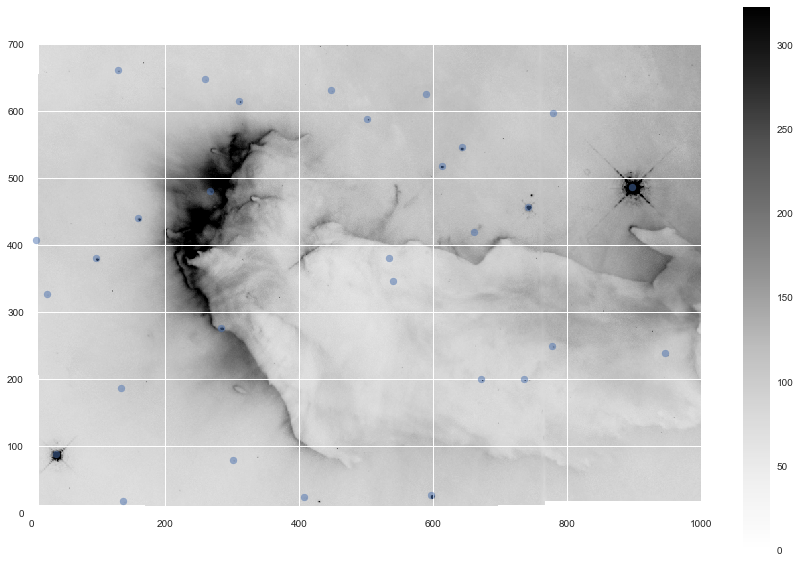

In [46]:
# Solution
# Convert coordinates to pixel positions
gaia_x, gaia_y = hst_image_wcs.all_world2pix(gaia_hdulist[1].data['ra'],
                                             gaia_hdulist[1].data['dec'],
                                             origin)

# Plot the image
my_python_ds9(hst_hdulist[0].data)

# Plot the sources
plt.scatter(gaia_x, gaia_y, alpha=0.5, marker='o')

# Focus over the region of interest
plt.xlim([0,1000])
plt.ylim([0,700])

#### Using WCS axes

X and Y in the plot correspond to the X and Y of the image. 
WCS axes allows you to plot sky coordinates without remapping the image pixels:

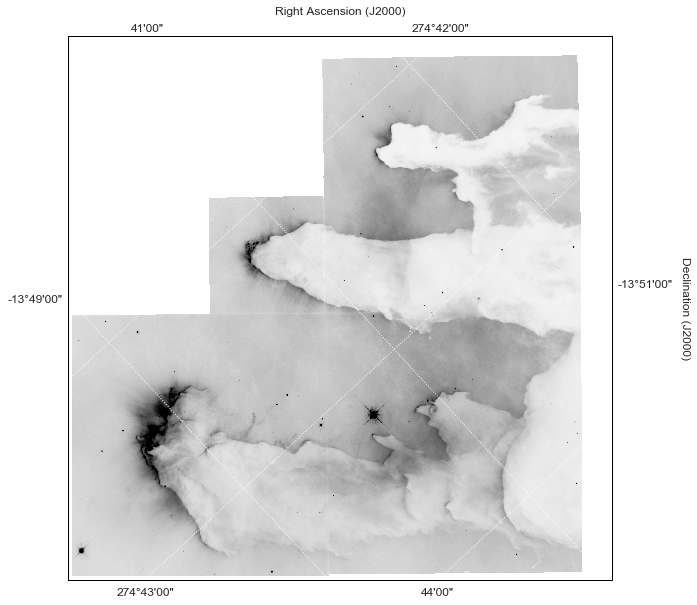

In [47]:
ax = plt.subplot(projection=hst_image_wcs)

ax.imshow(hst_hdulist[0].data, vmin=vmin, vmax=vmax, origin='lower')

overlay = ax.get_coords_overlay('fk5')
overlay.grid(color='white', ls='dotted')
overlay[0].set_axislabel('Right Ascension (J2000)')
overlay[1].set_axislabel('Declination (J2000)')

## Photometry

Before performing any photometry we need to have a first guess of the image background properties. For this section we will use a simpler optical image from the Sloan Digital Sky Survey (SDSS). This image contains the Spindle Galaxy, also known as Messier 102 or NGC 5866.

In [48]:
sdss_g_hdu_list = fits.open('../resources/sdss_g.fits')
sdss_g_hdu_list.info()

Filename: ../resources/sdss_g.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU      96   (2048, 1489)   float32   
  1              ImageHDU         6   (2048,)   float32   
  2              BinTableHDU     27   1R x 3C   [49152E, 2048E, 1489E]   
  3              BinTableHDU     79   1R x 31C   [J, 3A, J, A, D, D, 2J, J, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, E, E]   


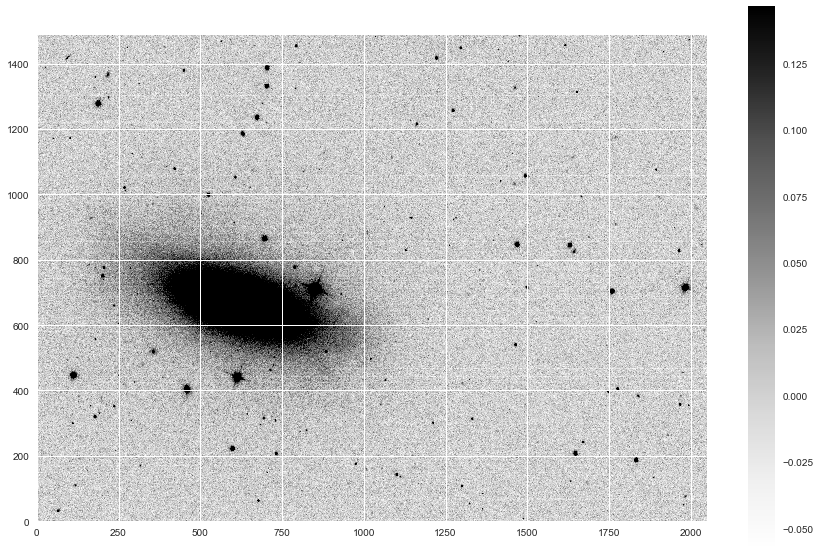

In [49]:
my_python_ds9(sdss_g_hdu_list[0].data)

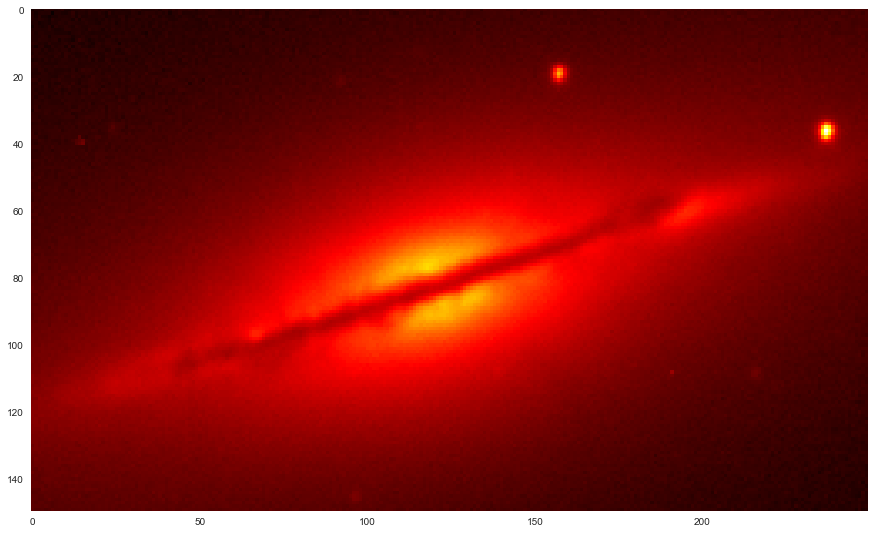

In [226]:
plt.imshow(np.power(sdss_g_hdu_list[0].data[ 580:730, 500:750], 0.5), cmap='hot')
plt.grid('off')

Let's get the basic statistics of it. For that we will need to remove the sources using a sigma clipping routine:

In [50]:
from astropy.stats import sigma_clipped_stats

mean, median, std = sigma_clipped_stats(sdss_g_hdu_list[0].data, sigma=3.0, iters=5)    
print((mean, median, std))    

(0.0051070779574767557, 0.0047531128, 0.022115232725526061)


We will need also the pixel scale that we can retrieve from the WCS:

In [51]:
sdss_g_image_wcs = wcs.WCS(sdss_g_hdu_list[0].header)
sdss_pixelscale = np.mean(wcs.utils.proj_plane_pixel_scales(sdss_g_image_wcs) * u.degree).to('arcsec')
sdss_pixelscale

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


<Quantity 0.39584320315411325 arcsec>

### Object detection

To detect the sources inside a astronomical image PhotUtils provides DAO Phot implementations to detect

In [182]:
from photutils import DAOStarFinder
sigma_detection = 5.0
daofind = DAOStarFinder(fwhm=1.5 * u.arcsec / sdss_pixelscale, threshold=sigma_detection*std)    
sources = daofind(sdss_g_hdu_list[0].data - median)    
print(sources)

 id   xcentroid     ycentroid   ...      flux           mag       
--- ------------- ------------- ... ------------- ----------------
  1 1486.63886453 6.30053397663 ... 3.81456101852   -1.45361141588
  2 1361.93787687 36.5524808735 ... 1.82762412747  -0.654717206957
  3 1976.45660478 49.5061657944 ... 2.99177126056    -1.1898209649
  4 1322.52235048 53.0372228974 ... 3.35279118786   -1.31351626593
  5 676.860624595 61.2975520886 ... 25.3621771224   -3.51046632804
  6 1795.99138246 70.3202435672 ... 1.10198813337  -0.105442294727
  7 1362.18608105 83.6213785613 ... 2.81264323781   -1.12278662185
  8 215.403302352 89.0072730582 ... 1.12510496041  -0.127982598563
  9 1297.75043743 106.586941913 ... 19.3390956567   -3.21609040388
 10 117.112749352 108.917304088 ... 1.96770599956  -0.734900524484
...           ...           ... ...           ...              ...
283 1915.14767029 1434.05895417 ... 1.13733606069   -0.13972202306
284 1409.41543986  1441.1432535 ... 1.31142945402  -0.29436233

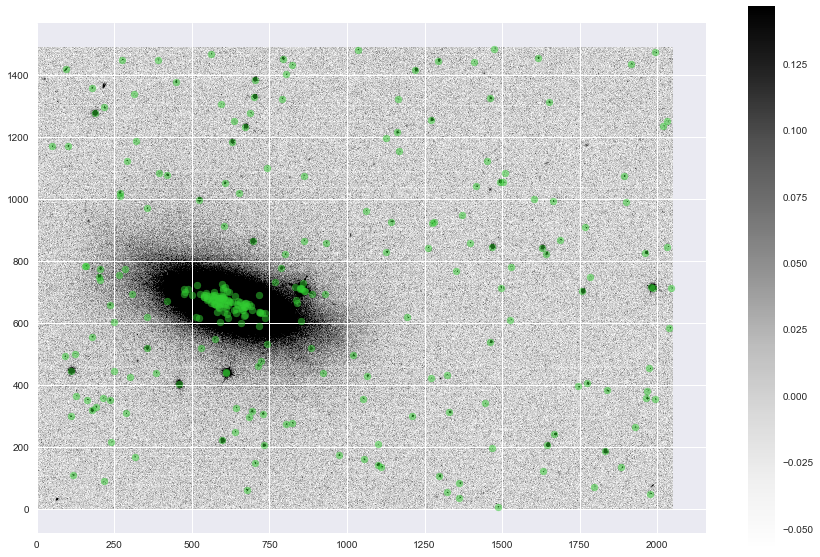

In [246]:
my_python_ds9(sdss_g_hdu_list[0].data)

plt.scatter(sources['xcentroid'], sources['ycentroid'], alpha=0.5, color='limegreen')

## PSF Modelling

We assumed that the image had a typical value of 1.5" per pixel. But we can make a more accurate estimation by fitting the pixels to a moffat profile around a detected star.

First, let's select the source we want to use for PSF modelling:

x pos: 1746.15302544
y pos: 395.207673208


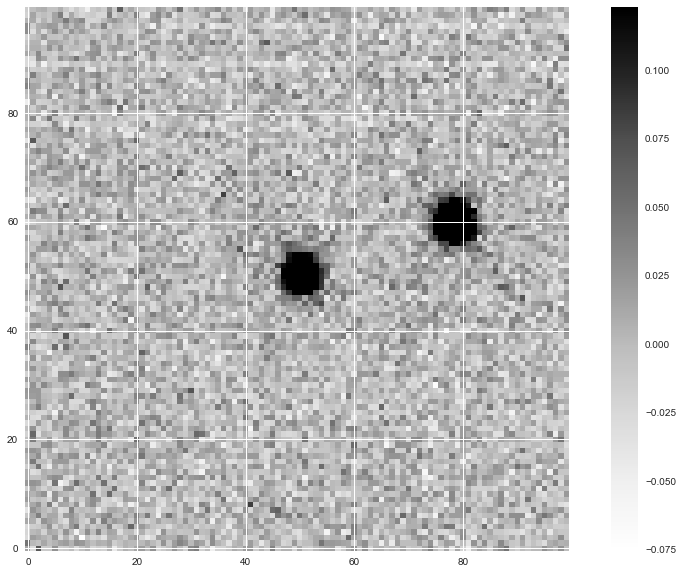

In [193]:
isource = sources[50]

# High SN - 50
# Low SN - 33
# Non-uniform background - 78

print ("x pos: " + str(isource['xcentroid']))
print ("y pos: " + str(isource['ycentroid']))

stamp_radius = 50
my_python_ds9(sdss_g_hdu_list[0].data[int(isource['ycentroid'] - stamp_radius):
                                      int(isource['ycentroid'] + stamp_radius), 
                                      int(isource['xcentroid'] - stamp_radius): 
                                      int(isource['xcentroid'] + stamp_radius)])

As we intend to find the profile of the source, we need to remove the possible sky background that lies behind:

In [194]:
# Median bkg subtracted image
bkg_subtracted_image = sdss_g_hdu_list[0].data - median

# 2D background subtracted - For later
#bkg_subtracted_image = sdss_g_hdu_list[0].data - bkg.background

To simplify the problem, we turn the 2D profile into a 1D distance array from the center of each pixel to the centroid of the source estimated by DAO Phot:

In [195]:
flux_counts = []
pixel_distance = []

x_cen = int(isource['xcentroid'])
y_cen = int(isource['ycentroid'])

# Pixels around detection loop
analysis_radius = 10
for x in range(x_cen - analysis_radius, x_cen + analysis_radius):
    for y in range(y_cen - analysis_radius, y_cen + analysis_radius):
        flux_counts.append(((bkg_subtracted_image[y][x]) / isource['peak']))
        pixel_distance.append(np.linalg.norm((isource['xcentroid'] - x, isource['ycentroid'] - y)))

Here we present two possible models that can fit the PSF distribution. A Gaussian and a Moffat profile:

In [196]:
from astropy.modeling import models, fitting

model = 'moffat'

if model == 'gaussian':
    # Fit the data using a Gaussian
    fwhm_best_guess = 1.5
    model_init = models.Gaussian1D(amplitude=1.0, mean=0, stddev=fwhm_best_guess)
elif model == 'moffat':
    # Fit the data using a Moffat
    model_init = models.Moffat1D(amplitude=1.0, x_0=0, gamma=2., alpha=3.5)
else:
    raise Exception("Unknown model type: %s. Must be gaussian or moffat." % model)

fitter = fitting.SimplexLSQFitter()
fitted_model = fitter(model_init, pixel_distance, flux_counts)

print ("Fit value:",  fitter.fit_info['final_func_val'])
print ("SN:", isource['flux'] * sigma_detection)

Fit value: 0.0870762591703
SN: 171.502079089


Once fitted the models, we need to convert from the parameters to the actual FWHM estimate.

In [197]:
# FHWM conversion
if model == 'gaussian':
    iFWHM = 2.355 * fitted_model.stddev * sdss_pixelscale.value
elif model == 'moffat':
    iFWHM = fitted_model.gamma * 2 * np.sqrt(2 ** (1. / fitted_model.alpha) - 1) * sdss_pixelscale.value
else:
    raise Exception("Unknown model type: %s. Must be gaussian or moffat." % model)

print ("FWHM estimated: ", iFWHM)

FWHM estimated:  1.08886790584


We can finally plot and see how the model traces the pixel values traces our fitted model.

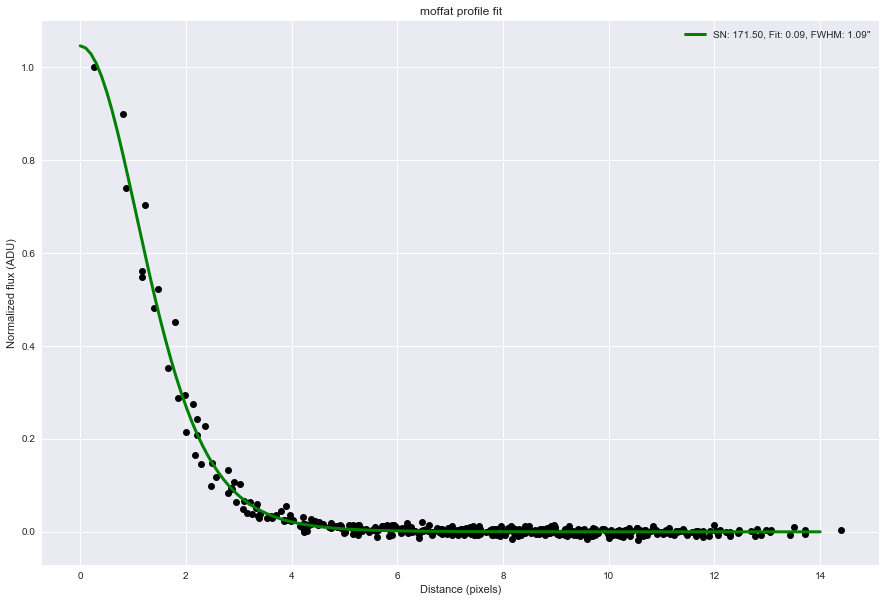

In [198]:
# Check fitting
if fitter.fit_info['final_func_val'] < 5.0:
    color = 'green'
else:
    color = 'red'
    
# Plot the data with the best-fit model
plt.figure()
plt.plot(pixel_distance, flux_counts, 'ko')
rx = np.linspace(0, int(max(pixel_distance)), int(max(pixel_distance)) * 10)
plt.plot(rx,
         fitted_model(rx),
         color=color,
         lw=3.0,
         label='SN: %.2f, Fit: %.2f, FWHM: %.2f"' % (isource['flux'] * sigma_detection,
                                                       fitter.fit_info['final_func_val'],
                                                       iFWHM))
plt.xlabel('Distance (pixels)')
plt.ylabel('Normalized flux (ADU)')
plt.title('%s profile fit' % model)
plt.legend()
plt.show()

### Background modelling

As we have seen in the case with non-uniform background, the constant median can be insuficient. Here we produce a 2D model of the background that can be subtracted from the original image to improve the modelling of the stars close to a very large extended source (or when the backrgound is not flat for any other reason)

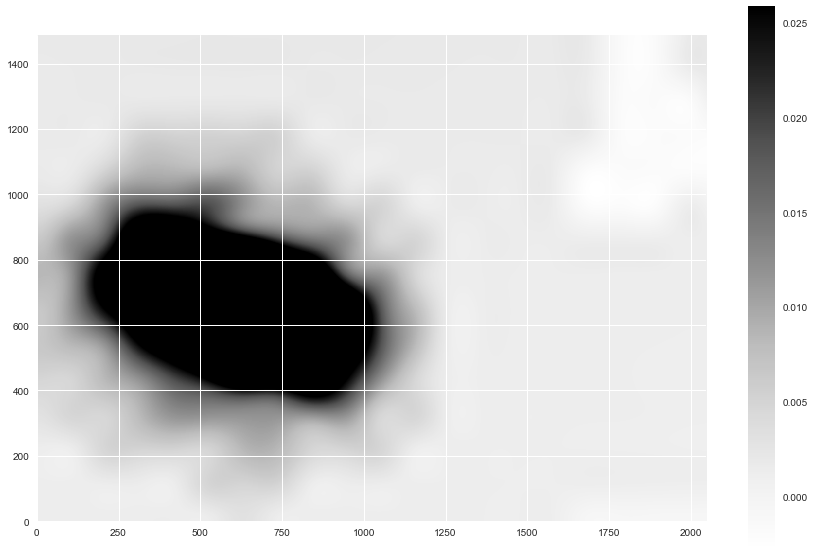

In [227]:
from photutils import Background2D, SigmaClip, MedianBackground
sigma_clip = SigmaClip(sigma=3., iters=10)
bkg_estimator = MedianBackground()
bkg = Background2D(data=sdss_g_hdu_list[0].data, 
                   box_size=(100, 100), 
                   filter_size=(3, 3),
                   sigma_clip=sigma_clip, 
                   bkg_estimator=bkg_estimator)
my_python_ds9(bkg.background)

Now let's go back to where the background was subtracted to verify the difference.

## Aperture photometry

We will work with the simple circular apertures. First we need to set the size we want and create the aperture objects:

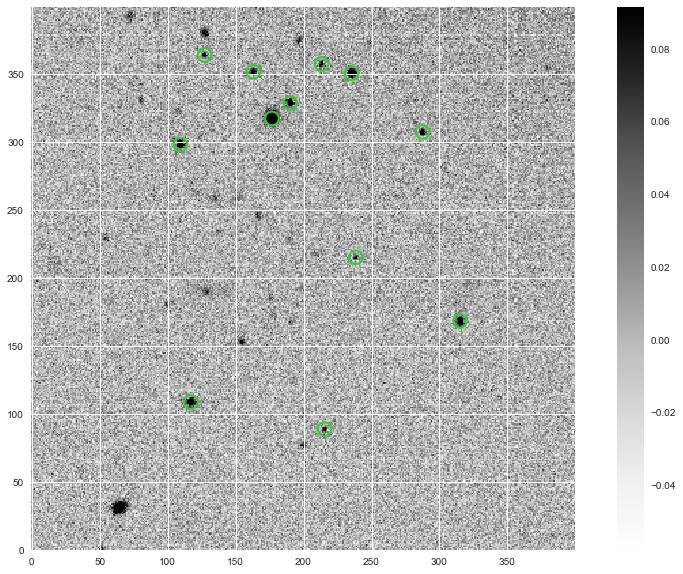

In [541]:
from photutils import CircularAperture

aperture_radius = 5.0

positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=aperture_radius)

my_python_ds9(sdss_g_hdu_list[0].data[0:400, 0:400])
apertures.plot(color='limegreen', lw=2)

### Global Background subtraction

As we only want the flux from the sources we are interested in, we need to remove the contribution from the background. The simplest way is to remove the median value constant of the sigma clipped image that we calculated before to the entire array:

In [542]:
from photutils import aperture_photometry

bkg_subtracted_image = sdss_g_hdu_list[0].data - median
phot_table_global_bkg = aperture_photometry(bkg_subtracted_image, apertures)
print (phot_table)

 id      xcenter       ...  aperture_sum_1 residual_aperture_sum
           pix         ...                                      
--- ------------------ ... --------------- ---------------------
  1  1486.638864525346 ...  0.620522946519         3.82225708915
  2  1361.937876867555 ... -0.138694719736         2.34584696455
  3 1976.4566047830601 ...  0.352375615143         3.19261651356
  4 1322.5223504784926 ... -0.989652113345         3.23481986898
  5  676.8606245948037 ...   0.76402552603         24.7163192972
  6  1795.991382458698 ...  -1.10134681987        0.824554713633
  7 1362.1860810499215 ... -0.476559506534         2.89159696337
  8  215.4033023515488 ...  0.138025177646         1.09314937917
  9 1297.7504374295183 ...  0.155816756399          20.645263334
 10  117.1127493520293 ... -0.431496239495          3.6516627308
...                ... ...             ...                   ...
284 1409.4154398615296 ...  0.512240853831         1.64612432129
285  1294.774715838578 ..

We could also remove the 2D background model that we calculated before, but it is usually more precise to create an annulus around the source we are interested in, and estimate the background level there.

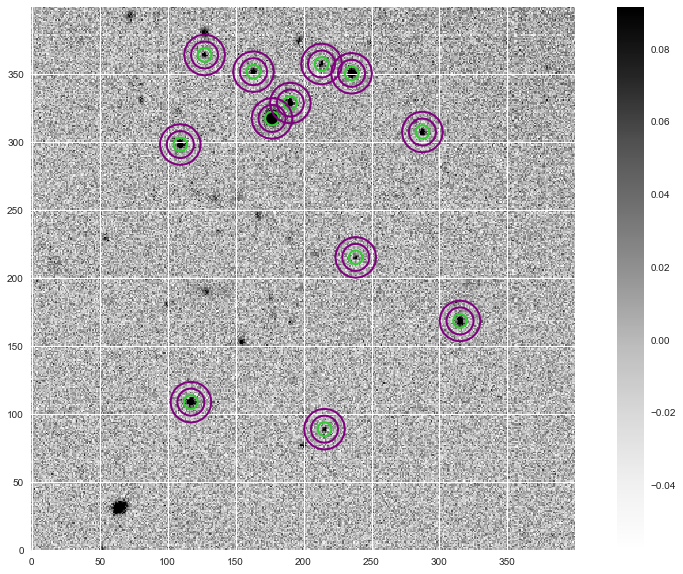

In [543]:
from photutils import CircularAnnulus
annulus_apertures = CircularAnnulus(positions, r_in=10, r_out=15)

my_python_ds9(sdss_g_hdu_list[0].data[0:400, 0:400])
apertures.plot(color='limegreen', lw=2)
annulus_apertures.plot(color='purple', lw=2, alpha=1)

The circular apertures and the annulus can be joined for a common photometry processing.

In [544]:
apers = [apertures, annulus_apertures]
phot_table_local_bkg = aperture_photometry(sdss_g_hdu_list[0].data, apers)
print(phot_table)    

 id      xcenter       ...  aperture_sum_1 residual_aperture_sum
           pix         ...                                      
--- ------------------ ... --------------- ---------------------
  1  1486.638864525346 ...  0.620522946519         3.82225708915
  2  1361.937876867555 ... -0.138694719736         2.34584696455
  3 1976.4566047830601 ...  0.352375615143         3.19261651356
  4 1322.5223504784926 ... -0.989652113345         3.23481986898
  5  676.8606245948037 ...   0.76402552603         24.7163192972
  6  1795.991382458698 ...  -1.10134681987        0.824554713633
  7 1362.1860810499215 ... -0.476559506534         2.89159696337
  8  215.4033023515488 ...  0.138025177646         1.09314937917
  9 1297.7504374295183 ...  0.155816756399          20.645263334
 10  117.1127493520293 ... -0.431496239495          3.6516627308
...                ... ...             ...                   ...
284 1409.4154398615296 ...  0.512240853831         1.64612432129
285  1294.774715838578 ..

Now we use the aperture_sum_1 to estimate the level of background around the source. We need to know the area of the annulus for this estimation:

In [545]:
bkg_mean = phot_table_local_bkg['aperture_sum_1'] / annulus_apertures.area()

And finally we can remove the background estimation to all pixels in the aperture:

In [546]:
bkg_sum = bkg_mean * apertures.area()
final_sum = phot_table_local_bkg['aperture_sum_0'] - bkg_sum
phot_table_local_bkg['residual_aperture_sum'] = final_sum
print(phot_table_local_bkg['residual_aperture_sum'])    

residual_aperture_sum
---------------------
        4.21036721099
        2.69674400406
        3.52828338461
        3.91270980062
        28.7952519533
        1.11907113931
          3.507040304
        1.24471008705
        24.1728167114
        5.53738978323
                  ...
        3.04226495063
        1.74608753458
        55.9327525152
        2.74848351096
        1.97581013336
         53.929489647
        16.0839914831
        3.97709054061
        3.17677906941
        2.34982300668
        2.80586526577
Length = 293 rows


In this comparison we see that many sources have the same flux with both methods but a significant amount of sources (the ones in the galaxy halo) have significantly more flux in the global subtraction method, as the flux from M102 is added to the one of the stars.

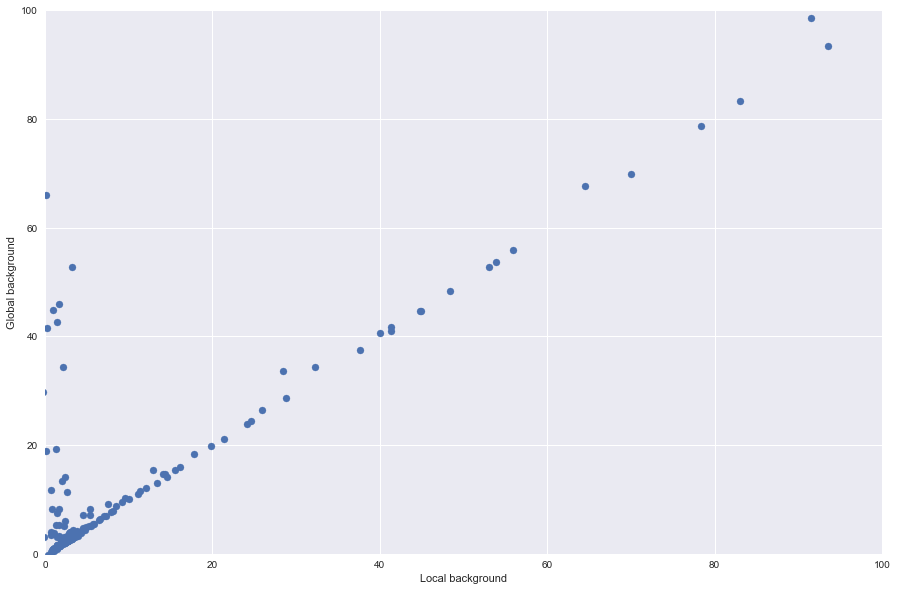

In [547]:
plt.scatter(phot_table_local_bkg['residual_aperture_sum'], phot_table_global_bkg['aperture_sum'])
plt.xlim(0,100)
plt.ylim(0,100)
plt.xlabel('Local background')
plt.ylabel('Global background')

Let's make a plot to verify this! Astropy qtables work similarly to Pandas, so we can make iloc searches.

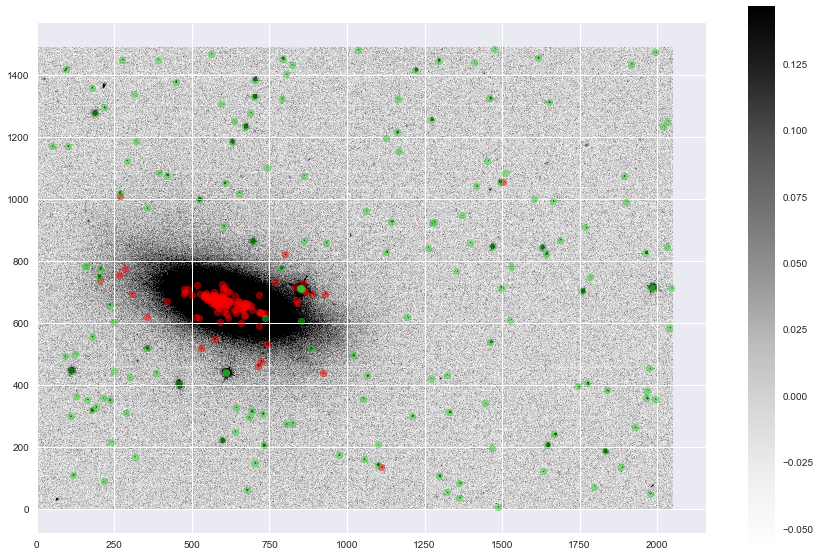

In [548]:
phot_table_local_bkg.add_index('id')
very_different = phot_table_local_bkg.iloc[phot_table_local_bkg['residual_aperture_sum'] * 1.5
                                           < phot_table_global_bkg['aperture_sum']]

quite_similar = phot_table_local_bkg.iloc[phot_table_local_bkg['residual_aperture_sum'] * 1.5
                                           > phot_table_global_bkg['aperture_sum']]

my_python_ds9(sdss_g_hdu_list[0].data)
plt.scatter(very_different['xcenter'], very_different['ycenter'], c='red', alpha=0.5)
plt.scatter(quite_similar['xcenter'], quite_similar['ycenter'], c='limegreen', alpha=0.5)

## Accessing to annulus pixels (if time allows)

## Error estimation (if time allows)

# Matching catalogues

In [549]:
sdss_r_hdu_list = fits.open('../resources/sdss_r.fits')
sdss_r_hdu_list.info()

Filename: ../resources/sdss_r.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU      96   (2048, 1489)   float32   
  1              ImageHDU         6   (2048,)   float32   
  2              BinTableHDU     27   1R x 3C   [49152E, 2048E, 1489E]   
  3              BinTableHDU     79   1R x 31C   [J, 3A, J, A, D, D, 2J, J, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, E, E]   


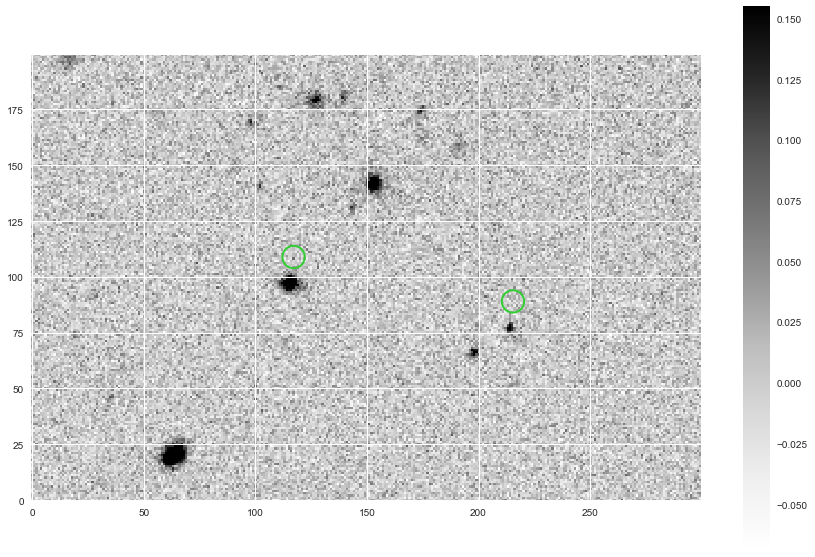

In [550]:
my_python_ds9(sdss_r_hdu_list[0].data[0:200, 0:300])
apertures.plot(color='limegreen', lw=2)

In [551]:
# Image statistics
mean_r, median_r, std_r = sigma_clipped_stats(sdss_r_hdu_list[0].data, sigma=3.0, iters=5)    

# Source detection
sources_r = daofind(sdss_r_hdu_list[0].data - median_r)    

# Apertures
positions_r = (sources_r['xcentroid'], sources_r['ycentroid'])
apertures_r = CircularAperture(positions_r, r=aperture_radius)

# Annulus
annulus_apertures_r = CircularAnnulus(positions_r, r_in=10, r_out=15)

# Photometry
apers_r = [apertures_r, annulus_apertures_r]
phot_table_local_bkg_r = aperture_photometry(sdss_r_hdu_list[0].data, apers_r)
bkg_mean_r = phot_table_local_bkg_r['aperture_sum_1'] / annulus_apertures_r.area()
bkg_sum_r = bkg_mean_r * apertures_r.area()
final_sum_r = phot_table_local_bkg_r['aperture_sum_0'] - bkg_sum_r
phot_table_local_bkg_r['residual_aperture_sum'] = final_sum_r

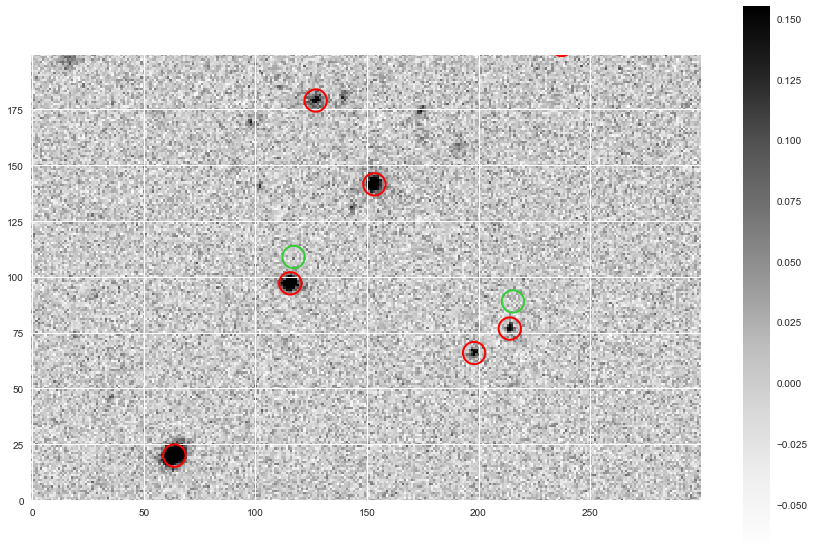

In [552]:
my_python_ds9(sdss_r_hdu_list[0].data[0:200, 0:300])
apertures.plot(color='limegreen', lw=2)
apertures_r.plot(color='red', lw=2)

First we create the two catalogues in sky coordinates using the WCS information

In [518]:
### g band catalogue ###
# Create wcs object
sdss_g_image_wcs = wcs.WCS(sdss_g_hdu_list[0].header)

# Pixels to Sky
lon_g, lat_g = sdss_g_image_wcs.all_pix2world(phot_table_local_bkg['xcenter'], 
                                              phot_table_local_bkg['ycenter'], 
                                              origin)
cat_g = SkyCoord(ra=lon_g*u.degree, dec=lat_g*u.degree)  


### r band catalogue ###
# Create wcs object
sdss_r_image_wcs = wcs.WCS(sdss_r_hdu_list[0].header)

# Pixels to Sky
lon_r, lat_r = sdss_r_image_wcs.all_pix2world(phot_table_local_bkg_r['xcenter'], 
                                          phot_table_local_bkg_r['ycenter'], 
                                          origin)
cat_r = SkyCoord(ra=lon_r*u.degree, dec=lat_r*u.degree)  

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


### Closest catalogue matching
The following function performs the matching between the two catalogues, and returns what is the closest "r" source to each of the "g" sources. Therefore the resulting arrays contain the same number of indices than the catalogue "g".

293


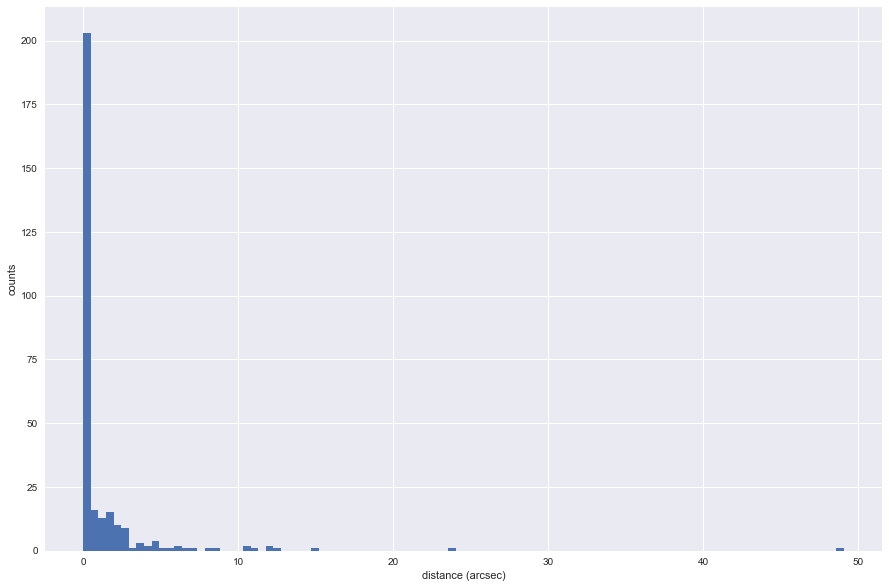

In [519]:
id_r, d2d, d3d = cat_g.match_to_catalog_sky(cat_r)

print (len(id_r))

hist_data = plt.hist(d2d.to('arcsec'), bins=100)
plt.xlabel('distance (arcsec)')
plt.ylabel('counts')

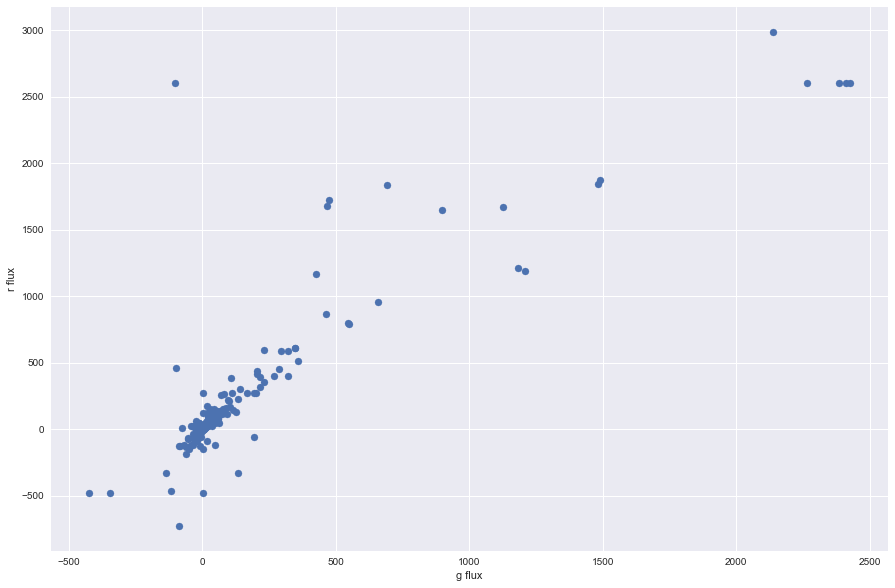

In [520]:
plt.scatter(phot_table_local_bkg['residual_aperture_sum'], phot_table_local_bkg_r[id_r]['residual_aperture_sum'])
plt.xlabel('g flux')
plt.ylabel('r flux')

### Search around coordinates matching
The following function performs the matching between the two catalogues, returning only those sources that match within certain tolerance in the sky. Therefore

224


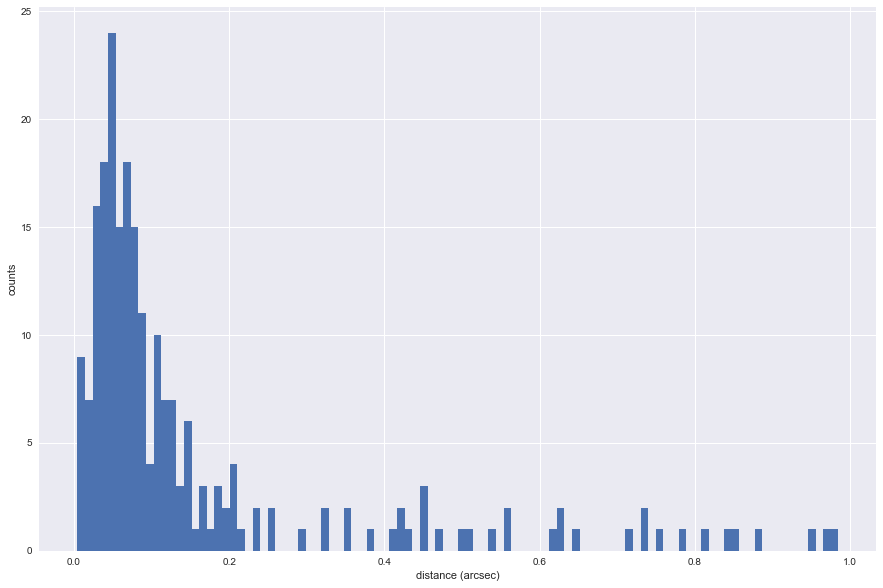

In [521]:
id_r_around, id_g_around, d2d_around, d3d_around = cat_g.search_around_sky(cat_r, 1*u.arcsec)  

print (len(id_r_around))

hist_data = plt.hist(d2d_around.to('arcsec'), bins=100)
plt.xlabel('distance (arcsec)')
plt.ylabel('counts')

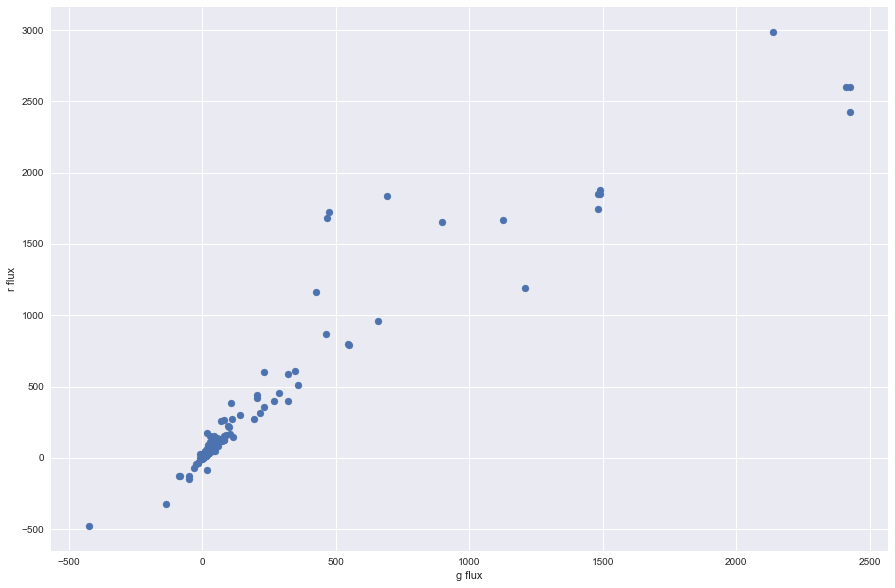

In [522]:
plt.scatter(phot_table_local_bkg[id_g_around]['residual_aperture_sum'], phot_table_local_bkg_r[id_r_around]['residual_aperture_sum'])
plt.xlabel('g flux')
plt.ylabel('r flux')

### From fluxes to magnitudes (in SDSS)
The images we use are already calibrated in photometry, and the units used are nanomaggies. Therefore

m = [22.5 mag] – 2.5 log10 f.

http://www.sdss.org/dr12/algorithms/magnitudes/#nmgy 

In [540]:
def to_sdss_mag(fluxes):
    return 22.5 - 2.5 * np.log(fluxes)

/Users/santi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


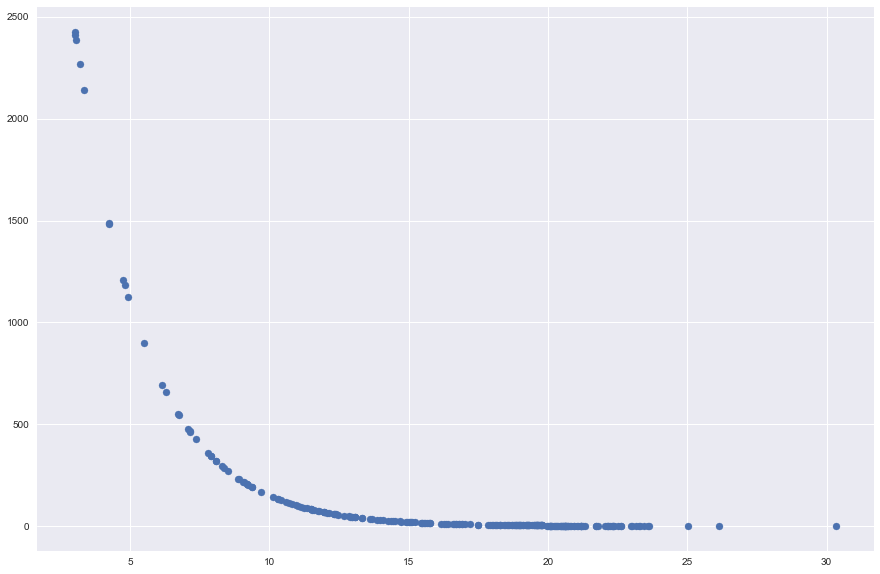

In [524]:
mags_g = 22.5 - 2.5 * np.log(phot_table_local_bkg['residual_aperture_sum'])
plt.scatter(mags_g, phot_table_local_bkg['residual_aperture_sum'])

### Matching to an external catalogue

Load the SDSS catalogue with astroquery that overlaps the image

In [536]:
from astroquery.sdss import SDSS
from astropy import coordinates as coords

region = np.mean(sdss_r_image_wcs.calc_footprint(), axis=0)
print (region[0])
c = SkyCoord(region[0] * u.degree, region[1] * u.degree, frame='icrs')

sdss_query = SDSS.query_region(c, spectro=False, radius=20*u.arcmin,  photoobj_fields=['ra','dec','u','g','r','i','z'])
print(sdss_query)

226.589346333
      ra           dec         u        g        r        i        z    
------------- ------------- -------- -------- -------- -------- --------
226.256060187 55.5783746844 21.19598 19.27753  17.9649 17.47445 17.14578
226.258778864  55.740360688 19.41701 18.27984 17.91591 17.78245  17.7054
226.263640718 56.0736987163 25.82107 23.65679 22.19713 21.40978 20.93486
226.264462613  55.739356294 25.12946 23.24296 21.40929 21.51575 20.50553
226.264798027 56.0391622332 23.35158  22.6752 22.24027 22.87081 21.43407
226.264961145  56.121875229 23.72188 22.79953 21.16498  20.5551  20.1204
  226.2667235 55.6952695062 23.55452  25.5639 24.44938 22.16438 22.35568
 226.26713454  55.803824095 25.53171 23.06941 22.10872 21.87997  20.4859
226.268655459 55.6756049565 22.70957 20.81281 19.52831 18.97327 18.68969
 226.26907714 56.0520442538  18.0173  16.9518 16.59925 16.48505 16.41915
          ...           ...      ...      ...      ...      ...      ...
226.908317725 55.9778617617 22.21526 

#### Checking the catalogue: Color - Color plot


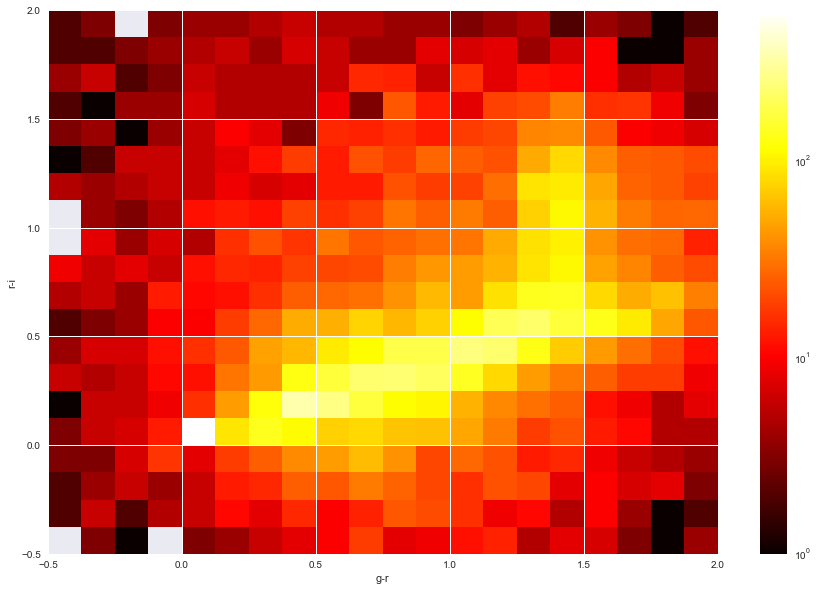

In [537]:
from matplotlib.colors import LogNorm

plt.hist2d(sdss_query['g']-sdss_query['r'], 
           sdss_query['r']-sdss_query['i'],
           range=[(-0.5,2), (-0.5,2)], 
           bins=20, 
           norm=LogNorm(),
          cmap='hot')
plt.colorbar()
plt.xlabel('g-r')
plt.ylabel('r-i')

595


/Users/santi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


(15, 25)

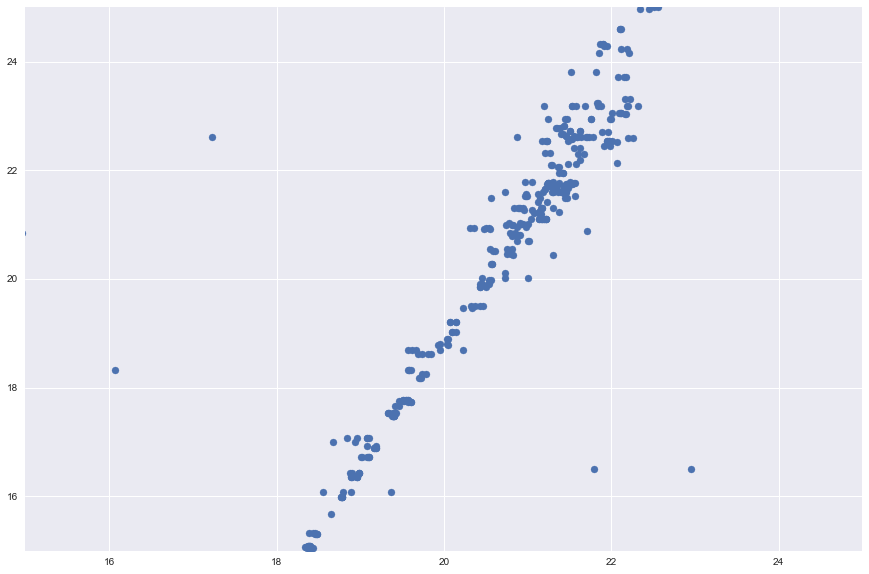

In [539]:
cat_sdss_query = SkyCoord(ra=sdss_query['ra']*u.degree, dec=sdss_query['dec']*u.degree)  

id_query_around, id_g_around, d2d_around, d3d_around = cat_g.search_around_sky(cat_sdss_query, 0.5*u.arcsec)  

print (len(id_query_around))

plt.scatter(sdss_query[id_query_around]['g'], to_sdss_mag(phot_table_local_bkg[id_g_around]['residual_aperture_sum']))
plt.xlim(15, 25)
plt.ylim(15,25)

## Exercise: Make r catalogue with sky coordinates
http://photutils.readthedocs.io/en/stable/photutils/aperture.html#aperture-photometry-using-sky-coordinates

## Image remapping with reproject (if time)
https://reproject.readthedocs.io/en/stable/

# Planning Observations

Astroplan section